# **Implementation of the Vision Transformer for Object Detection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing Libraries**

In [ ]:

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import os
import json

## **Data Preprocessing**

In [ ]:

tomato_base_dir = "/content/drive/MyDrive/tomato/"
path_images_train = os.path.join(tomato_base_dir, "train/")
path_annot_train = os.path.join(tomato_base_dir, "train/_annotations.coco.json")

In [ ]:
def custom_collate(batch):
    images, targets = zip(*batch)

    resized_images = [transforms.functional.resize(img, (32, 32)) for img in images]

    return resized_images, targets

In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set your paths
tomato_base_dir = "/content/drive/MyDrive/tomato/"
path_images_train = os.path.join(tomato_base_dir, "train/")
path_annot_train = os.path.join(tomato_base_dir, "train/_annotations.coco.json")

# Define your transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed (e.g., normalization, data augmentation)
])

# Create a CocoDataset using torchvision
coco_dataset = CocoDetection(root=path_images_train, annFile=path_annot_train, transform=transform)

# Define a DataLoader
trainloader = DataLoader(coco_dataset, batch_size=32, shuffle=True,collate_fn=custom_collate)

# Get one batch of images and annotations
dataiter = iter(trainloader)
images, targets = next(dataiter)



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## **Dividing the images into patches**

In [ ]:

def split_image_into_patches(images, patch_size):
    batch_size, num_channels, height, width = images.shape
    num_vert_patches = height // patch_size
    num_horiz_patches = width // patch_size

    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.reshape(batch_size, num_channels, num_vert_patches*num_horiz_patches, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4)
    patches = patches.reshape(batch_size, num_vert_patches*num_horiz_patches, num_channels*patch_size*patch_size)

    return patches

## **Visualizing the patches**

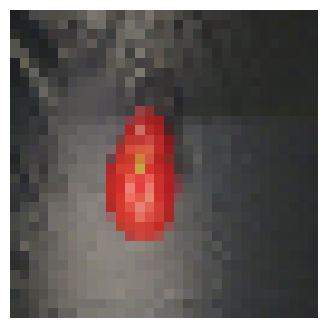

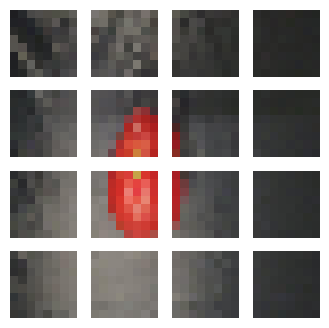

In [ ]:
# Get one batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Get one image from the batch
image = images[0]

# Split the image into patches
patches = split_image_into_patches(image.unsqueeze(0), 8)

# Calculate the number of patches in each dimension to create a 4x4 grid of 4x4 patches
num_patches = patches.shape[1]
num_cols = 4
num_rows = 4

# Display the original image
plt.figure(figsize=(4,4))
plt.imshow(np.moveaxis(image.numpy(), 0, -1))
plt.axis('off')
plt.show()

# Display the patches in a grid format
plt.figure(figsize=(4,4))
for i in range(num_rows):
    for j in range(num_cols):
        plt.subplot(num_rows, num_cols, i*num_cols+j+1)
        plt.imshow(np.transpose(patches[0, i*num_cols+j].reshape(3,8,8), (1,2,0)))
        plt.axis('off')
plt.show()

## **Function that takes the flattened patches and projects it to the embedding dimension**

In [ ]:

def embed_patches(patches, embedding_dim):

    # Define the linear embedding layer
    embed_layer = nn.Linear(in_features=patches.shape[-1], out_features=embedding_dim)

    # Apply the embedding layer to the flattened tensor
    embed_patches = embed_layer(patches)  # shape: [num_images * num_patches, embedding_dim]

    return embed_patches

## **Function to add the positional encoding to the embedding patches**


In [ ]:
def get_position_encoding(embeddings):
    num_images, num_patches, embedding_dim = embeddings.shape
    seq_length = num_patches * num_images
    num_patches = num_patches
    num_images = num_images

    pos_encoding = torch.zeros(seq_length, embedding_dim)
    position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2, dtype=torch.float) * (-math.log(10000.0) / embedding_dim))
    pos_encoding[:, 0::2] = torch.sin(position * div_term)
    pos_encoding[:, 1::2] = torch.cos(position * div_term)
    pos_encoding = pos_encoding[:num_patches, :].unsqueeze(0).repeat(num_images, 1, 1)
    pos_encoding = pos_encoding.reshape(-1, pos_encoding.size(-1))
    pos_encoding = pos_encoding.view(num_images, num_patches, embedding_dim)

    return pos_encoding


## **Encoder block function with Multi-head attention and the fully connected network**


In [ ]:
# Define the Encoder block with multi-head attention
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 6*embed_dim),
            nn.GELU(),
            nn.Linear(6*embed_dim, embed_dim)
        )

    def forward(self, x):
        # Layer normalization
        x_norm = self.norm1(x)

        # Multi-head attention with residual connection
        attn_output, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + attn_output

        # Layer normalization
        x_norm = self.norm2(x)

        # Feed-forward network with residual connection
        ffn_output = self.ffn(x_norm)
        x = x + ffn_output

        return x

## **MLP Classifer Head**

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.relu(out)
        # out = self.fc3(out)
        return out

## **Implementation of the ViT base Model for object Detection**

In [ ]:
class ViTObjectDetector(nn.Module):

    def __init__(self, inputs, patch_size, embed_dim, num_heads, mlp_head_units, hidden_size_classifier, num_classes_classifier, device):
        super(ViTObjectDetector, self).__init__()

        self.inputs = inputs
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_head_units = mlp_head_units
        self.hidden_size_classifier = hidden_size_classifier
        self.num_classes_classifier = num_classes_classifier
        self.device = device

        # Create class token
        self.class_token = nn.Parameter(torch.rand(1, self.embed_dim))

        # Create Encoder blocks
        encoder_blocks = []
        for i in range(2):
            encoder_blocks.append(EncoderBlock(self.embed_dim, self.num_heads))
        self.encoder_block = nn.Sequential(*encoder_blocks)

        # MLP head for object detection
        self.mlp_head = nn.Sequential(
            nn.Linear(2176, mlp_head_units),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(mlp_head_units, 4)  # Final four neurons that output bounding box
        )

        # MLP Classifier
        self.classifier = MLPClassifier(
            input_size=2176,
            hidden_size=hidden_size_classifier,
            num_classes=num_classes_classifier
        )

    def forward(self, inputs):
        # Split image into patches
        patches = split_image_into_patches(inputs, self.patch_size)

        # Embed patches
        embed_layer = embed_patches(patches, self.embed_dim)
        embedded_tokens = torch.stack([torch.vstack((self.class_token, embed_layer[i])) for i in range(len(embed_layer))])

        # Get position encoding
        pos_encoding = get_position_encoding(embedded_tokens)

        # Add position encoding to embedded patches
        embedded_patches = embedded_tokens + pos_encoding

        # Process through Encoder blocks
        encoded_sequence = self.encoder_block(embedded_patches)

        # Flatten for MLP
        flattened_representation = encoded_sequence.flatten(1)

        # Apply MLP for object detection
        bounding_box = self.mlp_head(flattened_representation)

        # Apply MLP Classifier
        classification_output = self.classifier(flattened_representation)

        return bounding_box, classification_output



In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTObjectDetector(inputs = (32,3,32,32), patch_size=8, embed_dim = 128, num_heads= 2, mlp_head_units = 512, hidden_size_classifier=256,
    num_classes_classifier=3 , device=device )

model.to(device)

ViTObjectDetector(
  (encoder_block): Sequential(
    (0): EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=768, out_features=128, bias=True)
      )
    )
    (1): EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2):